# RRAM Relaxation Data Notebook

This notebook contains the analysis on empirical RRAM relaxation data across three technologies (A, B, C). It loads and processes the measurements taken for each technology.

In [1]:
# Imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
# from matplotlib.offsetbox import AnchoredText

## Load the data and settings

Below, choose which technology to load data and settings for:

In [2]:
# Choose technology here
TECH = "C"
FULLDATA = False

In [107]:
# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

In [4]:
# Load data for technology
colnames = ["addr", "time", "r", "g"]
if FULLDATA: # Load full dataset
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
    tsdata = pd.read_csv(f"data/tech{TECH}/tsdata.tsv.gz", names=colnames, sep='\t')
else: # Load small dataset (only includes data that is actually used)
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", names=colnames, sep='\t')
    tsdata = pd.read_csv(f"data/tech{TECH}/tsdata.min.tsv.gz", names=colnames, sep='\t')

## Time series analysis
In this section, we will look at example time series data on a log scale and also examine the power spectral density (PSD). First, choose the ranges to analyze:

In [5]:
# Get ranges to plot time series and PSD for
ranges = np.array([0, 8, 16, 31])

# Get addrs to plot time series PSD for
if FULLDATA:
    # Use PSD index offsets to select the correct cells
    indices = ranges + np.array(settings["ts_index_offsets"]) * 32

    # Output data to small file
    fopts = {"sep": '\t', "header": False, "index": False}
    addrs = tsdata[tsdata["time"] == 0]["addr"].to_numpy()[indices]
    tsdata[tsdata["addr"].isin(addrs)].to_csv(f"data/tech{TECH}/tsdata.min.tsv.gz", **fopts)
else:
    # Use indices sequentially if using minimal data set
    indices = range(len(ranges))
addrs = tsdata[tsdata["time"] == 0]["addr"].to_numpy()[indices]

### Example Time Series Data

Below, we can look at the time series data for the ranges chosen above:

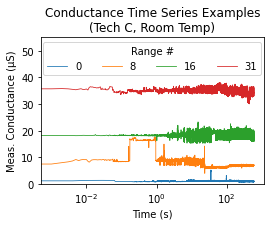

In [6]:
# Plot long-term power spectral density (PSD)
fig = plt.figure(figsize=(4,2.7))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Time Series Examples\n(Tech {TECH}, Room Temp)")
for r, addr in zip(ranges, addrs):
    # Select data
    d = tsdata[(tsdata["addr"] == addr) & (tsdata["time"] >= 0) & (tsdata["time"] < 1e10)]

    # Plot time series data
    plt.plot(d["time"], d["g"]*1e6, label=r, linewidth=0.8)

# Format and display
ax.legend(title="Range #", ncol=4, loc=9)
ax.set_ylim(*settings["ts_ylim"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Meas. Conductance (µS)")
ax.set_xscale("log")
plt.show()

### Power Spectral Density (PSD)

In this section, we will look at the PSDs to understand the relaxation behavior better:

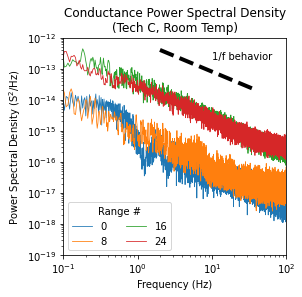

In [97]:
# Plot power spectral density (PSD)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Power Spectral Density\n(Tech {TECH}, Room Temp)")
slopes = []
for r, addr in zip(ranges, addrs):
    # Select data
    d = tsdata[(tsdata["addr"] == addr) & (tsdata["time"] >= 0) & (tsdata["time"] < 1e10)]

    # # Lomb-Scargle PSD
    # f = np.logspace(np.log10(1/600), np.log10(2), 500)
    # f = np.logspace(np.log10(2), np.log10(400/2), 1000)
    # p = scipy.signal.lombscargle(d["time"], d["g"], f)

    # Welch PSD
    f, p = scipy.signal.welch(d["g"], fs=settings["fs"], nperseg=settings["psd_nperseg"])
    plt.plot(f, p, label=r, linewidth=0.8)

    # # Power law fit
    # a, b = np.polyfit(np.log(f[[30,-30]]), np.log(p[[30,-30]]), 1)
    # print(f"Range {r} slope: {a}")
    # slopes.append(a)
    # plt.plot(f[1:], np.exp(a*np.log(f[1:]) + b), 'k--', zorder=10, linewidth=2)

    # # 1/f fit
    # fitfn = lambda logf, A: A - logf
    # params, _ = scipy.optimize.curve_fit(fitfn, np.log(f), np.log(p))
    # A = params[0]
    # print(A)
    # plt.plot(f, np.exp(fitfn(np.log(f), A)), 'k--', zorder=10, linewidth=2)

# Format and display
# ax.add_artist(AnchoredText("Slopes: [%.2f, %.2f]" % (max(slopes), min(slopes)), loc=1, frameon=False))
plt.plot(*settings["psd_fpts"], 'k--', zorder=10, linewidth=4)
ax.legend(title="Range #", ncol=2)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (S$^2$/Hz)")
ax.set_xscale("log")
ax.set_xlim(*settings["psd_xlim"])
ax.set_ylim(*settings["psd_ylim"])
ax.set_yscale("log")
plt.text(*settings["psd_ftextloc"], "1/f behavior")
plt.show()

## Relaxation data analysis

Here, we will be analyzing the large dataset relaxation behavior. We will examine: (1) examples of conductance distribution broadening behavior over time, (2) scatterplot of conductance deviation vs. conductance, (3) standard deviation vs. time for different starting conductance values.

In [8]:
# Select times to study
times = [0, 0.01, 0.1, 1, 10, 100000]

if FULLDATA:
    # Get color
    tdata = []
    for time in times:
        idx = (data["time"] - time).abs().groupby(data["addr"]).idxmin()
        tdata.append(data[data.index.isin(idx)])
    tdata = pd.concat(tdata)

    # Write to file
    fopts = {"sep": '\t', "header": False, "index": False}
    tdata[colnames].to_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", **fopts)
else:
    tdata = data

# Conductance range and initial conductance attributes
tdata["gi"] = tdata.groupby("addr").transform("first")["g"]
tdata["range"] = np.int16(np.floor(tdata["gi"] / settings["gmax"] * 32))

### Conductance distribution broadening behavior

Below are examples of conductance broadening behavior over time:

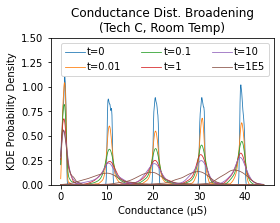

In [21]:
# Select ranges to study
ranges = [0, 8, 16, 24, 31]

# Conductance broadening behavior
fig = plt.figure(figsize=(4, 2.7))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Dist. Broadening\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(times, colors):
    for r in ranges:
        gx = np.linspace(0, settings["gmax"]*1.1e6, 500)
        np.seterr(divide = "ignore") 
        rlog = lambda x : np.round(np.log10(x))
        gvals = tdata[(tdata["range"] == r) & (rlog(tdata["time"]) == rlog(time))]["g"]
        pdf = scipy.stats.gaussian_kde(gvals*1e6).pdf(gx)
        label = (f"t={time}" if time < times[-1] else "t=1E5") if r == 0 else None
        plt.plot(gx, pdf, color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2)
ax.set_ylim(*settings["gbroad_ylim"])
ax.set_xlabel("Conductance (µS)")
ax.set_ylabel("KDE Probability Density")
plt.show()

### Mean Drift and Variance Growth (Time Dependence)
Here, we examine the drift of the distribution mean and variance growth as a function of time.

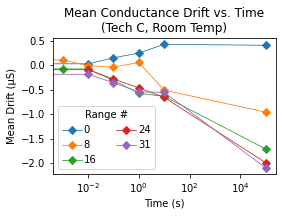

In [116]:
# Mean drift behavior (time dependence)
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.set_title(f"Mean Conductance Drift vs. Time\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for r, color in zip(ranges, colors):
    d = tdata[(tdata["range"] == r) & (tdata["gi"] <= settings["gmax"])]
    ts = rlog(tdata["time"])
    gi = d.groupby(ts).mean()["gi"]*1e6
    gf = d.groupby(ts).mean()["g"]*1e6
    std = d.groupby(ts).std()["g"]*1e6
    deltag = gf - gi
    plt.plot(10**deltag.index, deltag, '-D', color=color, label=r, linewidth=0.8)
ax.legend(title="Range #", ncol=2, handletextpad=0.2)
#ax.set_ylim(*settings["gmeandrift_gi_ylim"])
ax.set_xscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean Drift (µS)")
plt.show()

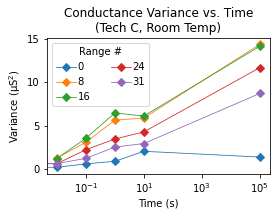

In [115]:
# Variance behavior (time dependence)
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Variance vs. Time\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for r, color in zip(ranges, colors):
    d = tdata[(tdata["range"] == r) & (tdata["gi"] <= settings["gmax"])]
    ts = rlog(tdata["time"])
    gi = d.groupby(ts).mean()["gi"]*1e6
    gfvar = d.groupby(ts).var()["g"]*(1e6**2)
    plt.plot(10**gfvar.index, gfvar, '-D', color=color, label=r, linewidth=0.8)
ax.legend(title="Range #", ncol=2, handletextpad=0.2)
#ax.set_ylim(*settings["gmeandrift_gi_ylim"])
ax.set_xscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Variance (µS$^2$)")
plt.show()

### Mean Drift and Variance Growth (Conductance Dependence)
Here, we examine the drift of the distribution mean and variance growth as a function of conductance.

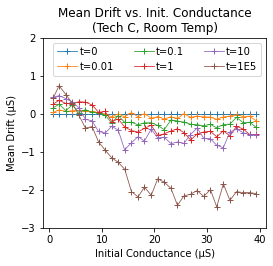

In [111]:
# Mean drift behavior (conductance dependence)
fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
ax.set_title(f"Mean Drift vs. Init. Conductance\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(times, colors):
    np.seterr(divide = "ignore")
    rlog = lambda x : np.round(np.log10(x))
    d = tdata[(rlog(tdata["time"]) == rlog(time)) & (tdata["gi"] <= settings["gmax"])]
    gi = d.groupby("range").mean()["gi"]*1e6
    gf = d.groupby("range").mean()["g"]*1e6
    deltag = gf - gi
    label = f"t={time}" if time < times[-1] else "t=1E5"
    plt.plot(gi, deltag, '-+', color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2)
ax.set_ylim(*settings["gmeandrift_gi_ylim"])
ax.set_xlabel("Initial Conductance (µS)")
ax.set_ylabel("Mean Drift (µS)")
plt.show()

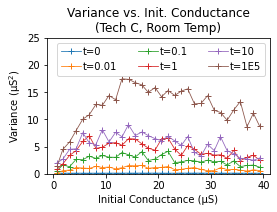

In [117]:
# Variance behavior (conductance dependence)
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.set_title(f"Variance vs. Init. Conductance\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(times, colors):
    np.seterr(divide = "ignore")
    rlog = lambda x : np.round(np.log10(x))
    d = tdata[(rlog(tdata["time"]) == rlog(time)) & (tdata["gi"] <= settings["gmax"])]
    gi = d.groupby("range").mean()["gi"]*1e6
    gfvar = (d.groupby("range")).var()["g"]*(1e6**2)
    label = f"t={time}" if time < times[-1] else "t=1E5"
    plt.plot(gi, gfvar, '-+', color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2)
ax.set_ylim(*settings["gvar_gi_ylim"])
ax.set_xlabel("Initial Conductance (µS)")
ax.set_ylabel("Variance (µS$^2$)")
plt.show()